In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt



In [2]:
# Define the image preprocessing steps
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define the function to extract the features from an image
def extract_features(image_path, model):
    # Open the image and apply the preprocessing steps
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)
    # Extract the features using the model
    with torch.no_grad():
        features = model(image_tensor).squeeze()
    # Normalize the features to unit length
    features /= features.norm()
    # Convert the features to a numpy array
    features = features.numpy()
    return features

In [3]:
import os 
import random 
import shutil

# Set the path to the data folder
data_path = r"/Users/prudhvid/Desktop/db_prj/167/"

# Set the path to the training, validation, and test folders
train_path = r"/Users/prudhvid/Desktop/db_prj/167/train/"
val_path = r"/Users/prudhvid/Desktop/db_prj/167/val/"
test_path = r"/Users/prudhvid/Desktop/db_prj/167/test/"

# Set the split ratios between training, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Create the training, validation, and test folders if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get the list of all image files in the data folder
image_files = [f for f in os.listdir(data_path) if f.endswith(".jpg")]

# Shuffle the image files randomly
random.shuffle(image_files)

# Split the image files into training, validation, and test sets
train_index = int(len(image_files) * train_ratio)
val_index = int(len(image_files) * (train_ratio + val_ratio))
train_image_files = image_files[:train_index]
val_image_files = image_files[train_index:val_index]
test_image_files = image_files[val_index:]

# Copy the training images to the training folder
for image_file in train_image_files:
    src_path = os.path.join(data_path, image_file)
    dst_path = os.path.join(train_path, image_file)
    shutil.copyfile(src_path, dst_path)

# Copy the validation images to the validation folder
for image_file in val_image_files:
    src_path = os.path.join(data_path, image_file)
    dst_path = os.path.join(val_path, image_file)
    shutil.copyfile(src_path, dst_path)

# Copy the test images to the test folder
for image_file in test_image_files:
    src_path = os.path.join(data_path, image_file)
    dst_path = os.path.join(test_path, image_file)
    shutil.copyfile(src_path, dst_path)


In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        
        for filename in os.listdir(self.data_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                self.images.append(os.path.join(self.data_dir, filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, 0  # All images belong to a single class, so we can assign a fixed label value to all of them


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os

train_data_path = r"/Users/prudhvid/Desktop/db_prj/167/train/"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dataset = CustomDataset(train_data_path, train_transforms)


# Set num_samples to the number of samples in train_dataset
num_samples = len(train_dataset)


# Define the validation dataset
val_data_path = r"/Users/prudhvid/Desktop/db_prj/167/val/"

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
val_dataset = CustomDataset(val_data_path, val_transforms)

# Set num_samples to the number of samples in train_dataset
num_samples = len(val_dataset)

# Define the test dataset
test_data_path = r"/Users/prudhvid/Desktop/db_prj/167/test/"

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_dataset = CustomDataset(test_data_path, test_transforms)

# Set num_samples to the number of samples in test_dataset
num_samples = len(test_dataset)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load the VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    # Train the model on the training dataset
    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_dataset)

    # Evaluate the model on the validation dataset
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)
    
    
    # Evaluate the model on the test dataset
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_acc += torch.sum(preds == labels.data)
    test_loss /= len(test_dataset)
    test_acc /= len(test_dataset)


    # Construct the confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, test_preds)

    # Print the confusion matrix
    print(cm)

Running on cpu
Validation Accuracy: 100.00%
Epoch 1/10, Train Loss: 0.1625, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 9/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


In [22]:
# Define the function to retrieve the most similar images to a query image
def retrieve_similar_images(query_image_path, database_df, model, top_k=10):
    # Extract the features of the query image
    query_features = extract_features(query_image_path, model)

    # Compute the distances between the query image and all the images in the database
    distances = np.linalg.norm(database_df['embedding'].tolist() - query_features, axis=1)

    # Retrieve the indices of the top-k most similar images
    top_k_indices = np.argsort(distances)[:top_k]

    # Get the image paths and distances of the top-k most similar images
    top_k_image_paths = database_df.loc[top_k_indices, 'image_path'].tolist()
    top_k_distances = distances[top_k_indices]

    # Return the top-k most similar images along with their image paths and distances
    return list(zip(top_k_image_paths, top_k_distances))

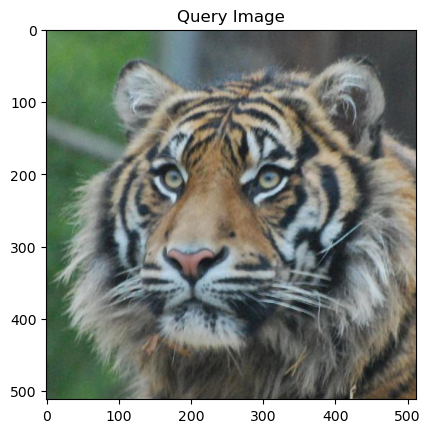

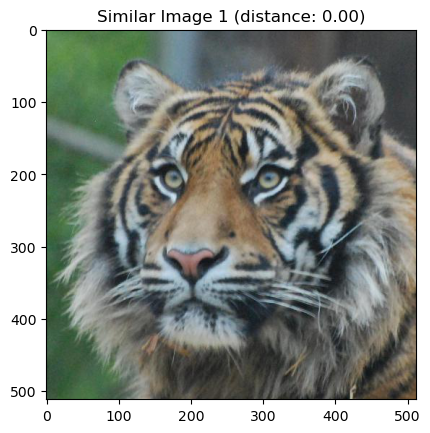

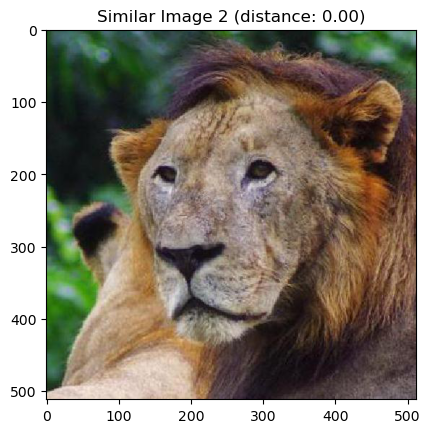

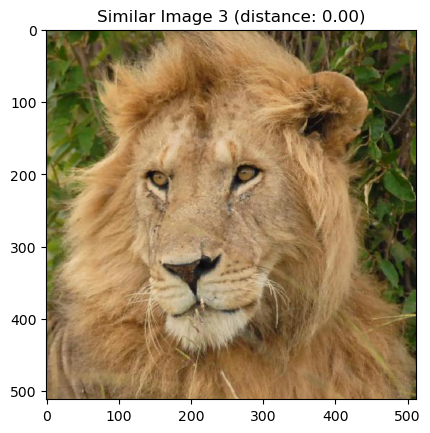

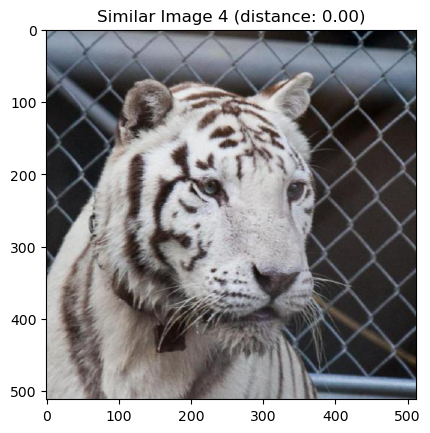

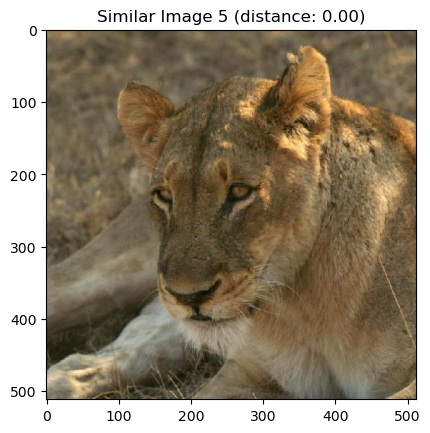

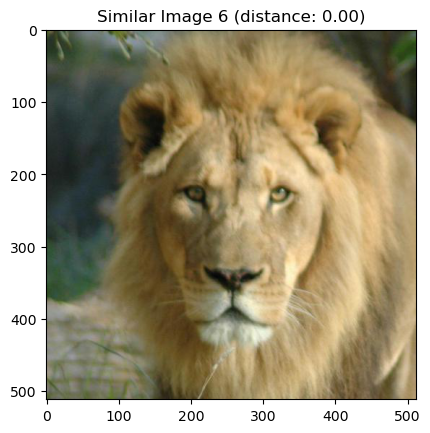

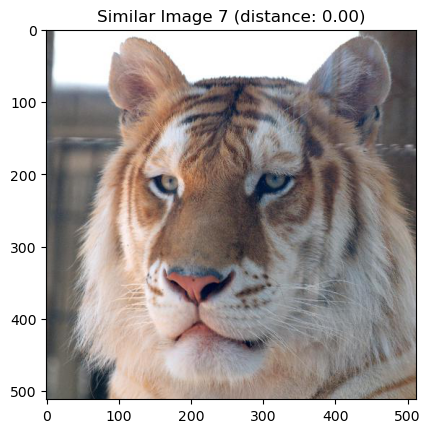

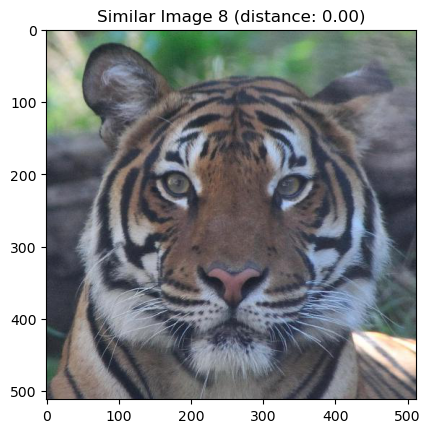

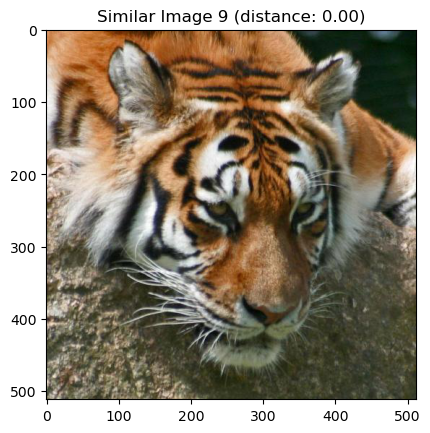

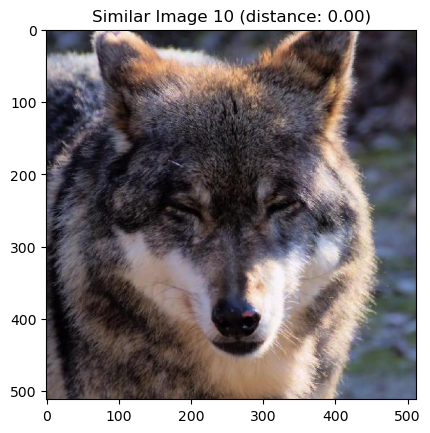

In [ ]:
# Load the image database and preprocess all the images
database_path = Path("/Users/prudhvid/Desktop/db_prj/167/")
image_paths = list(database_path.glob("*.jpg"))
image_embeddings = [extract_features(str(image_path), model) for image_path in image_paths]
df = pd.DataFrame({'image_path': image_paths, 'embedding': image_embeddings})

# Retrieve similar images for a query image
query_image_path = "/Users/prudhvid/Desktop/db_prj/167/15.jpg"
similar_images = retrieve_similar_images(query_image_path, df, model, top_k=10)

# Display the query image
query_image = Image.open(query_image_path)
plt.imshow(query_image)
plt.title('Query Image')
plt.show()

# Display the similar images
for i, (image_path, distance) in enumerate(similar_images):
    similar_image = Image.open(image_path)
    plt.imshow(similar_image)
    plt.title(f'Similar Image {i+1} (distance: {distance:.2f})')
    plt.show()
